
## Classifying movie genre based on text from [Wikipedia](https://wikipedia.org) pages of movies.

> Assignment from **WiseStep Inc.**

---

### Neccessary imports

In [1]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from datetime import datetime
import pickle
from sklearn.linear_model import LogisticRegression
import joblib

DATA_DIR = '../data/'

---

# Assignment Overview

---
## Step 1

```

Write a script in any language of your choice and scrape 1000 wikipedia pages related to movies and store the following attributes about them in any human readable fileformat : Movie name, Main Actor(s), Year of Release

```

**Problem** - Since Wikipedia has billions of pages. Hence, without manually filtering out pages related to movies, it will be very tedious and time consuming to first store 1000 movie names and then scrape these 1000 movie names to fetch required attributes.

---

**Solution** - Instead of manually storing 1000 movie names and then scraping 1000 pages of the movies' wikipedia, I broke the solution into 2 parts.

I have written 2 _python3_ scripts. One script first scrapes the iMDB website to fetch 1000 movie names. The movie names are stored and then these 1000 movies' wikipedia pages are scraped to collect required attributes.

The 2 _python3_ scripts are :

    - ../modules/get_movie_names.py
    - ../modules/get_wiki_data.py


---

### Step 1 - Part 1

---

> Collecting 1000 movie names

The script ``` ../modules/get_movie_names.py ``` uses BeautifulSoup4 as scarping library to go through iMDB pages and store 1000 movies' names.

Page scraped - [Top 1000 movies ever made](https://www.imdb.com/list/ls056549735/?st_dt=&mode=detail&page=1&sort=list_order,asc)

In [2]:
from modules import get_movie_names

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
get_movie_names.fetch_movie_names()

Fetching 1000 movie names from 10 pages...


100%|██████████| 10/10 [02:51<00:00, 15.07s/it]

1000 movie names fetched and stored as csv under ../data/raw/unclean_movie_names.csv


Now we have names of 1000 movies fetched from iMDB website. We can use these names to scrape data from their respective Wikipedia pages.

But these names are not in plain text right now. They have unwanted characters appended to them.

A special function to clean the movie names is present in the ```get_movie_names.py``` script. This will clean the text to get it ready to scrape Wikipedia pages.


---

<h4 style="color:red">Movie names before cleaning</h4>

In [4]:
uncleaned_movie_names = pd.read_csv(DATA_DIR+'raw/unclean_movie_names.csv')

In [5]:
uncleaned_movie_names.shape

(1000, 1)

In [6]:
uncleaned_movie_names.head()

,name
0,\n1.\nThe Godfather\n(1972)\n
1,\n2.\nThe Godfather: Part II\n(1974)\n
2,\n3.\nSchindler's List\n(1993)\n
3,\n4.\nThe Lord of the Rings: The Return of the...
4,\n5.\nOne Flew Over the Cuckoo's Nest\n(1975)\n


In [7]:
uncleaned_movie_names.name[54]

'\n55.\nThe Last Emperor\n(1987)\n'


---

<h4 style="color:green">Movie names after cleaning</h4>

In [8]:
get_movie_names.cleanMovieName()

Cleaning movie names...
Movie names cleaned and stored under ../data/processed/clean_movie_names.csv


In [9]:
cleaned_movie_names = pd.read_csv(DATA_DIR+'processed/clean_movie_names.csv')

In [10]:
cleaned_movie_names.shape

(1000, 1)

In [11]:
cleaned_movie_names.head()

,text
0,The Godfather
1,The Godfather: Part II
2,Schindler's List
3,The Lord of the Rings: The Return of the King
4,One Flew Over the Cuckoo's Nest


In [12]:
cleaned_movie_names.text[54]

'The Last Emperor'

---

### Step 1 - Part 2

---

> Collecting attributes for movie names by scraping Wikipedia pages of respective movie.

The script ``` ../modules/get_wiki_data.py ``` uses BeautifulSoup4 as scarping library to go through Wikipedia pages of respective movie names and fetches the following attributes.

- Cast
- Year Of Release
- Plot (Text on Wikipedia)



In [17]:
from modules import get_wiki_data

In [18]:
get_wiki_data.fetch_attributes_from_wikipedia()

Fetching movie attributes..



Data fetching from Wikipedia completed! Results stored under ../data/unseen/unseen_data.csv


Now we have fetched the required attributes of the respective movies.

This data will also act as our unseen data since we will be classifying these movies in to different genres.

### A look at newly fetched unseen data

In [20]:
unseen_data = pd.read_csv(DATA_DIR+'unseen/unseen_data.csv')

In [39]:
unseen_data.tail()

,title,cast,release_year,plot
763,Fast Times at Ridgemont High,\nSean Penn\nJennifer Jason Leigh\nJudge Reinh...,"\nAugust 13, 1982 (1982-08-13)\n",NABrad Hamilton is a popular senior at Ridgemo...
764,Stand and Deliver,\nEdward James Olmos\nLou Diamond Phillips\nRo...,"\nFebruary 13, 1988 (1988-02-13) (Miami)\nMarc...","NAIn the early 1980s, Jaime Escalante becomes ..."
765,Silkwood,\nMeryl Streep\nKurt Russell\nCher\n,"\nDecember 14, 1983 (1983-12-14)\n","NAKaren Silkwood, a worker at the Kerr-McGee C..."
766,There's Something About Mary,\nCameron Diaz\nMatt Dillon\nBen Stiller\nLee ...,"\nJuly 15, 1998 (1998-07-15)\n","NAIn 1985, 16-year-old high school student The..."
767,Bull Durham,\nKevin Costner\nSusan Sarandon\nTim Robbins\n...,"\nJune 15, 1988 (1988-06-15)\n",NAMinor League baseball single-A team the Durh...


<hr style="height:1px;border:none;color:#333;background-color:#333;" />


## Step 2

```
Classify the scraped pages into 6 genres listed below by using the text in the wikipedia pages using 
any Model or mathematical method i.e. the text in the wikipedia page should be the basis of classification.

Romance
Action
Suspense
Horror
Science Fiction
Others

```

> To solve this problem, I will be using supervised machine learning, by training learning algorithms on labelled data. The learning algorithm will be of classifier nature.

**Problem** - To train a classifier to be able to classify movies based on text into the above mentioned genres, I will be needing labelled data.

**Solution** - I have collected and merged data from multiple online available repositories to generate my own labelled training data.

The links to various repositories used to create training data are as followed:

- [CMU Movie Corpus](http://www.cs.cmu.edu/~ark/personas/)
- [Kaggle Movie Data](https://www.kaggle.com/lokkagle/movie-genre-data)
- [Wikipedia Movie Plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)


The raw data downloaded from the above mentioned links is stored under ```../data/train/raw/```

---

* I have written a script, stored under ```../modules/prepare_training_data.py ```to aggregate all these datasets by filtering out unneccesary data points and keeping only what's required.

### Step 2 - Part 1

> Preparing training data

In [40]:
!python3 ../modules/prepare_training_data.py

42303it [00:01, 29004.53it/s]
100%|████████████████████████████████| 42303/42303 [00:00<00:00, 1313481.45it/s]


<hr style="height:1px;border:none;color:#333;background-color:#333;" />

<h2 style="text-align:center">Training Data Overview</h2>

> The processed training data is stored under ``` ../data/train/processed/train_data.csv ```

## Exploratory Data Analysis
---

In [41]:
train_data = pd.read_csv(DATA_DIR+'train/processed/train_data.csv')

In [42]:
train_data.shape

(7979, 5)

In [43]:
train_data.head()

,Cast,Genre,Plot,Release Year,Title
0,NaN,action,The film features a train traveling through th...,1906,From Leadville to Aspen: A Hold-Up in the Rockies
1,Charles Inslee,others,A white girl (Florence Lawrence) rejects a pro...,1908,The Call of the Wild
2,James Cruze,horror,White-haired Dr. Jekyll has secretly locked hi...,1912,Dr. Jekyll and Mr. Hyde
3,King Baggot,horror,Dr. Henry Jekyll (King Baggot) sends a note to...,1913,Dr. Jekyll and Mr. Hyde
4,"William Garwood, Marie Eline",others,The Evidence of the Film tells the story of a ...,1913,The Evidence of the Film


#### Example data point

In [44]:
print("Cast\n{}".format(train_data.iloc[4].Cast))
print("-"*100)
print("Genre\n{}".format(train_data.iloc[4].Genre))
print("-"*100)
print("Plot\n{}".format(train_data.iloc[4].Plot))
print("-"*100)
print("Release Year\n{}".format(train_data.iloc[4]['Release Year']))
print("-"*100)
print("Title\n{}".format(train_data.iloc[4].Title))

Cast
William Garwood, Marie Eline
----------------------------------------------------------------------------------------------------
Genre
others
----------------------------------------------------------------------------------------------------
Plot
The Evidence of the Film tells the story of a messenger boy at a film studio who is wrongfully accused of stealing bonds worth $20,000. He is saved by his sister, a film cutter, who comes across some footage of her brother inadvertently walking into a location shot and being knocked down by the real-life villain.
----------------------------------------------------------------------------------------------------
Release Year
1913
----------------------------------------------------------------------------------------------------
Title
The Evidence of the Film


### Checking the frequency of genres

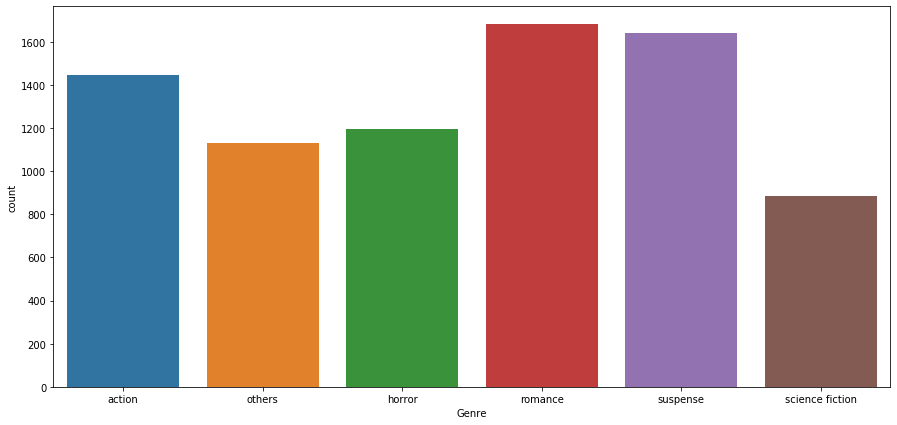

In [45]:
plt.figure(figsize=(15,7)) 
sns.countplot(train_data.Genre)

> Since we will not be using a movies' Year of Release, Cast, and Title to train our learning algorithms because these attributes do not supply any information for the genre of the movie. We will be dropping these attributes.

In [46]:
train_data.head()

,Cast,Genre,Plot,Release Year,Title
0,NaN,action,The film features a train traveling through th...,1906,From Leadville to Aspen: A Hold-Up in the Rockies
1,Charles Inslee,others,A white girl (Florence Lawrence) rejects a pro...,1908,The Call of the Wild
2,James Cruze,horror,White-haired Dr. Jekyll has secretly locked hi...,1912,Dr. Jekyll and Mr. Hyde
3,King Baggot,horror,Dr. Henry Jekyll (King Baggot) sends a note to...,1913,Dr. Jekyll and Mr. Hyde
4,"William Garwood, Marie Eline",others,The Evidence of the Film tells the story of a ...,1913,The Evidence of the Film


In [47]:
train_data.drop(columns=['Cast','Title','Release Year'],axis=1,inplace=True)

In [48]:
train_data.head()

,Genre,Plot
0,action,The film features a train traveling through th...
1,others,A white girl (Florence Lawrence) rejects a pro...
2,horror,White-haired Dr. Jekyll has secretly locked hi...
3,horror,Dr. Henry Jekyll (King Baggot) sends a note to...
4,others,The Evidence of the Film tells the story of a ...


In [49]:
train_data.isna().sum()

Genre    0
Plot     0
dtype: int64

> We do not have any NA values in the data.

In [50]:
train_data.isnull().sum()

Genre    0
Plot     0
dtype: int64

> Neither we have any Null values in the data.

## Cleaning and Text Preprocessing

In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samarsrivastava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

> I will be using very basic cleaning methods as the data is scraped from Wikipedia pages of movies, I don't expect html tags or any other special characters except, dashes, backslash apostrophes, extra white spaces. Also I will be normalizing the words into lower case in order to keep the feature space tight and restricted.


---

<h4 style="color:red">A data point before cleaning.</h4>

In [52]:
train_data.Plot[4]

'The Evidence of the Film tells the story of a messenger boy at a film studio who is wrongfully accused of stealing bonds worth $20,000. He is saved by his sister, a film cutter, who comes across some footage of her brother inadvertently walking into a location shot and being knocked down by the real-life villain.'

In [53]:
import re
x = train_data.Plot[4]
temp_dict = {}
special_chars = re.sub('[\w]+' ,'',x)
numbers = sum(char.isdigit() for char in x)
letters = sum(char.isalpha() for char in x)
others  = len(x) - numbers - letters
temp_dict['Total Characters'] = len(x)
temp_dict['Special Characters'] = len(special_chars)
temp_dict['Numbers'] = numbers
temp_dict['Letters'] = letters
temp_dict['Others'] = others
temp_dict        
    

{'Total Characters': 314,
 'Special Characters': 62,
 'Numbers': 5,
 'Letters': 247,
 'Others': 62}

In [54]:
def clean_text(text):
    text = re.sub("\'", "", text) #Removing backslashes
    text = re.sub("[^a-zA-Z]"," ",text) #Keeping english alphabets only
    text = ' '.join(text.split()) #Striping extra white-spaces
    text = text.lower() #Normalizing text
    return text

In [55]:
train_data['plot_cleaned'] = train_data.Plot.apply(lambda x: clean_text(x))


---

<h4 style="color:green">A data point after cleaning.</h4>

In [56]:
train_data.plot_cleaned[4]

'the evidence of the film tells the story of a messenger boy at a film studio who is wrongfully accused of stealing bonds worth he is saved by his sister a film cutter who comes across some footage of her brother inadvertently walking into a location shot and being knocked down by the real life villain'

In [57]:
import re
y = train_data.plot_cleaned[4]
temp_dict = {}
special_chars = re.sub('[\w]+' ,'',y)
numbers = sum(char.isdigit() for char in y)
letters = sum(char.isalpha() for char in y)
others  = len(y) - numbers - letters
temp_dict['Total Characters'] = len(y)
temp_dict['Special Characters'] = len(special_chars)
temp_dict['Numbers'] = numbers
temp_dict['Letters'] = letters
temp_dict['Others'] = others
temp_dict        
    

{'Total Characters': 302,
 'Special Characters': 55,
 'Numbers': 0,
 'Letters': 247,
 'Others': 55}

> The 55 special characters and spaces that we see are spaces between words.

**Quick look at the data again**

In [58]:
train_data.head()

,Genre,Plot,plot_cleaned
0,action,The film features a train traveling through th...,the film features a train traveling through th...
1,others,A white girl (Florence Lawrence) rejects a pro...,a white girl florence lawrence rejects a propo...
2,horror,White-haired Dr. Jekyll has secretly locked hi...,white haired dr jekyll has secretly locked him...
3,horror,Dr. Henry Jekyll (King Baggot) sends a note to...,dr henry jekyll king baggot sends a note to hi...
4,others,The Evidence of the Film tells the story of a ...,the evidence of the film tells the story of a ...


In [59]:
train_data.plot_cleaned[3]

'dr henry jekyll king baggot sends a note to his fianc e alice jane gail and her father matt b snyder to say that instead of accompanying them to the opera he must give more time to his charity patients at jekyll s practice his friends dr lanyon howard crampton and utterson william sorrel a lawyer ridicule him for what they consider his dangerous research alice and her father also visit jekyll s rooms but although apologetic the doctor insists on devoting his time to his patients that night however jekyll undertakes a dangerous experiment swallowing a drug intended to releases his evil self his body convulses and he transforms into a hunched twisted figure the strange creature emerges from jekyll s room bearing a note in jekyll s handwriting that orders the household staff to treat the stranger mr hyde as himself hyde then slips out into the night terrorising the patrons of a nearby tavern before finding himself lodgings from these rooms he begins a career of evil until one night he at

### Visualization of most frequent words in movie plots

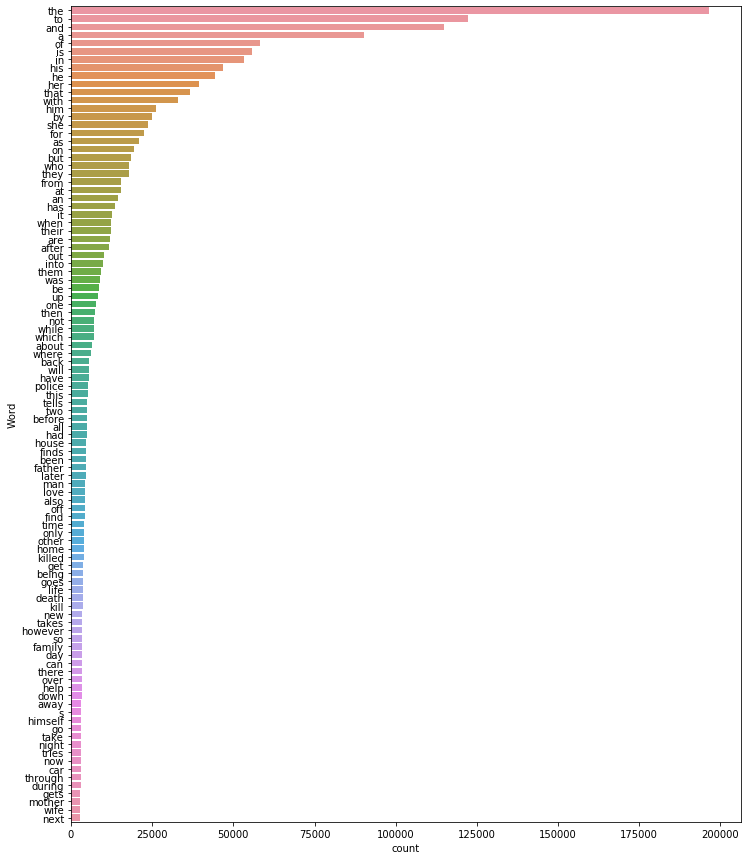

In [60]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(train_data.plot_cleaned, 100)

> As expected, the word ``` the ``` is the most frequent word in movie plots. Supports the hypothesis of English language.

### Removing stopwords and performing stemming

> Since stop words don't really add any meaning to a sentence. For this task we will be removing them.

In [62]:
train_data.drop(columns=['Plot'],axis=1,inplace=True)

In [63]:
train_data.head()

,Genre,plot_cleaned
0,action,the film features a train traveling through th...
1,others,a white girl florence lawrence rejects a propo...
2,horror,white haired dr jekyll has secretly locked him...
3,horror,dr henry jekyll king baggot sends a note to hi...
4,others,the evidence of the film tells the story of a ...


In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train_data['plot_cleaned'] = train_data['plot_cleaned'].apply(lambda x: remove_stopwords(x))

In [70]:
def stem_corpus(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(text)
train_data['plot_cleaned'] = train_data['plot_cleaned'].apply(lambda x: stem_corpusm_corpus(x))

In [71]:
train_data.plot_cleaned[4]

'evidence film tells story messenger boy film studio wrongfully accused stealing bonds worth saved sister film cutter comes across footage brother inadvertently walking location shot knocked real life villain'

### Visualizing frequency of words after common words(stop words) are removed.

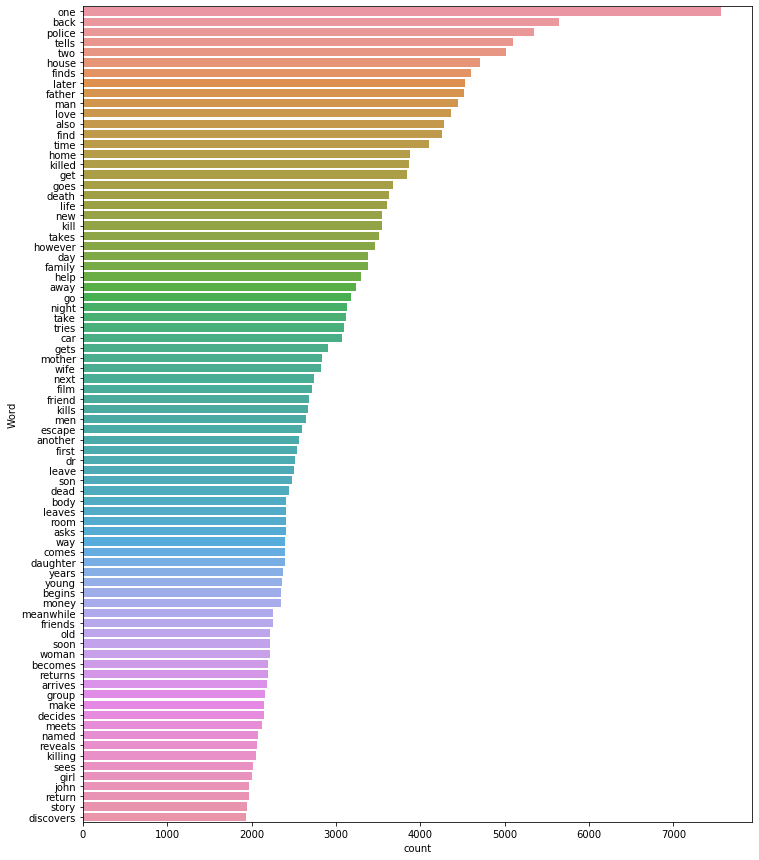

In [72]:
freq_words(train_data['plot_cleaned'], 80)

> As we can see, now the most frequent words are not the most common words of English language. Hence now we can get more knowledge out of the Wikipedia text.

---

## Split data into train and test
> For evaluation purposes

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(train_data['plot_cleaned'],
                                                    train_data['Genre'], test_size=0.2, random_state=42)

In [77]:
X_train.shape

(6383,)

In [78]:
y_train.shape

(6383,)

In [79]:
X_test.shape

(1596,)

In [80]:
y_test.shape

(1596,)

In [81]:
X_train.head(5)

6110    badal bobby deol young man tragic childhood ch...
5684    story film deals underworld revolves around am...
5503    superintendent wai michael miu organises opera...
1488    optimistic psychiatrist dr donovan macleod wan...
7808    story aging actress disabled child agrees larg...
Name: plot_cleaned, dtype: object

In [82]:
y_train.head(5)

6110             action
5684           suspense
5503             others
1488           suspense
7808    science fiction
Name: Genre, dtype: object

In [83]:
X_test.head()

2570    trust concerns unusual romance two young misfi...
3139    late los angeles hannon fuller mueller stahl o...
7139    opening scene shows anjali sindhu tolani sitti...
3787    story told flashback cia agent marcus jones re...
7788    teenager lily works checkout girl local superm...
Name: plot_cleaned, dtype: object

In [87]:
y_test.head()

2570            romance
3139    science fiction
7139             action
3787             action
7788           suspense
Name: Genre, dtype: object

#### Mapping genres to numericals

In [88]:
genre_map = {'action':0,'suspense':1,'romance':2,'science fiction':3,'others':4,'horror':5}

In [94]:
y_train = y_train.map(genre_map)

In [92]:
y_test = y_test.map(genre_map)

In [95]:
y_test.head()

2570    2
3139    3
7139    0
3787    0
7788    1
Name: Genre, dtype: int64

In [93]:
y_test.value_counts()

1    338
2    329
0    274
4    236
5    224
3    195
Name: Genre, dtype: int64

<h2 style="text-align:center">Converting Text into features</h2>

> For this we will be using TF-IDF vectorizer. 

Term Frequency Formula
![tf_formula](https://miro.medium.com/max/420/1*T-K5vPy1IROvrQe-Wh_CLA.png)

> Here f(w,d) is the frequency of word w in document d.

Inverse Document Frequency Formula
![idf_formula](https://miro.medium.com/max/458/0*YcSQWBsLk9t5FaVJ.png)
> With N documents in the dataset and f(w, D) the frequency of word w in the whole dataset, this number will be lower with more appearances of the word in the whole dataset.
Here f(w,d) is the frequency of word w in document d.


Tf-Idf Formula
![tf_idf_formula](https://miro.medium.com/max/556/0*rs8otIUS1Vu3nOMY.png)


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [100]:
tf_idf_vectorizer = TfidfVectorizer(lowercase=True)

In [102]:
X_train_vectorized = tf_idf_vectorizer.fit_transform(X_train)

In [105]:
print(tf_idf_vectorizer.get_feature_names()[900:910])

['afn', 'afoot', 'aforementioned', 'aforesaid', 'afoul', 'afraid', 'afresh', 'africa', 'african', 'africans']


In [106]:
X_train_vectorized.shape

(6383, 64524)

In [107]:
X_test_vectorized = tf_idf_vectorizer.transform(X_test)

In [108]:
X_test_vectorized.shape

(1596, 64524)

## Training the learning algorithm


(Alpha tuning using GridSearchCV)

## OneVsAll Approach via Logistic Regression

0.001
{'estimator__alpha': [0.001], 'estimator__loss': ['log'], 'estimator__penalty': ['l2']}
Gridsearchcv
fit model
0.01
{'estimator__alpha': [0.01], 'estimator__loss': ['log'], 'estimator__penalty': ['l2']}
Gridsearchcv
fit model
0.1
{'estimator__alpha': [0.1], 'estimator__loss': ['log'], 'estimator__penalty': ['l2']}
Gridsearchcv
fit model

 The optimal value of alpha with penalty=l2 and loss= log is 0.


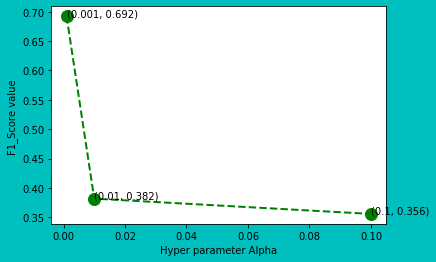

Time taken to run this cell : 0:00:10.851738


In [111]:
start = datetime.now()
alpha=[10**-3,10**-2,10**-1]

import warnings
warnings.filterwarnings('ignore')

# hp1={'estimator__C':alpha}

cv_scores = []
for i in alpha: 
    print(i)
    hp1={'estimator__alpha':[i],
         'estimator__loss':['log'],
         'estimator__penalty':['l2']}
    print(hp1)
    classifier = OneVsRestClassifier(SGDClassifier())

    model11 =GridSearchCV(classifier,hp1,
                          cv=3, scoring='f1_micro',n_jobs=-1)
    print("Gridsearchcv")
    best_model1=model11.fit(X_train_vectorized, y_train)
    print('fit model')
    Train_model_score=best_model1.score(X_train_vectorized, 
                                        y_train)
#print("best_model1")
    cv_scores.append(Train_model_score.mean())

fscore = [x for x in cv_scores]

# determining best alpha

optimal_alpha21 = alpha[fscore.index(max(fscore))]
print('\n The optimal value of alpha with penalty=l2 and loss= log is %d.' % optimal_alpha21)

# Plots
fig4 = plt.figure( facecolor='c', edgecolor='k')
plt.plot(alpha, fscore,color='green', marker='o', linestyle='dashed',
linewidth=2, markersize=12)

for xy in zip(alpha, np.round(fscore,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyper parameter Alpha')
plt.ylabel('F1_Score value ')
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

In [112]:
print(optimal_alpha21)

0.001


### Machine Learning

In [115]:
best_model1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=optimal_alpha21,
                                               penalty='l2'), n_jobs=-1)
best_model1.fit(X_train_vectorized, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, loss='log'), n_jobs=-1)

### Evaluation

In [116]:
predictions = best_model1.predict(X_test_vectorized)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-averasge quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions)) 
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.5557644110275689
Micro-averasge quality numbers
Precision: 0.5558, Recall: 0.5558, F1-measure: 0.5558
Macro-average quality numbers
Precision: 0.6676, Recall: 0.5141, F1-measure: 0.5096
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       274
           1       0.43      0.69      0.53       338
           2       0.55      0.93      0.69       329
           3       0.95      0.31      0.47       195
           4       0.74      0.12      0.21       236
           5       0.72      0.49      0.58       224

    accuracy                           0.56      1596
   macro avg       0.67      0.51      0.51      1596
weighted avg       0.64      0.56      0.52      1596

Time taken to run this cell : 0:04:56.433016


## XGBoost Classifier

In [128]:
from sklearn.ensemble import GradientBoostingClassifier

In [129]:
xgBoost = GradientBoostingClassifier()

In [134]:
parameters = {'learning_rate':[0.2,0.5,0.3],'n_estimators':[100,50,500]}

In [135]:
xgBoost_tuned = GridSearchCV(xgBoost,parameters)

In [ ]:
xgBoost_tuned.fit(X_train_vectorized,y_train)

### Evaluation

In [ ]:
predictions = xgBoost_tuned.predict(X_test_vectorized)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-averasge quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions)) 
print("Time taken to run this cell :", datetime.now() - start)